# Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.



### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [0]:
# ! pip install SimpleITK==1.2.2 
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
# ! unzip brainage-data.zip 

# data directory
data_dir = 'data/brain_age/'

### Running on DoC lab machines

In [0]:
# data directory
data_dir = './data/brain_age/'#'/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [0]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

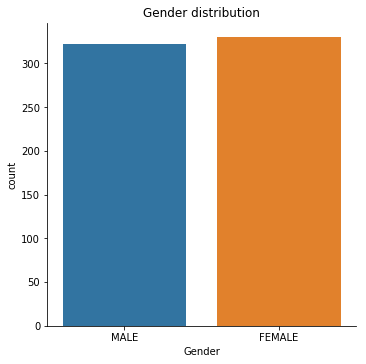

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


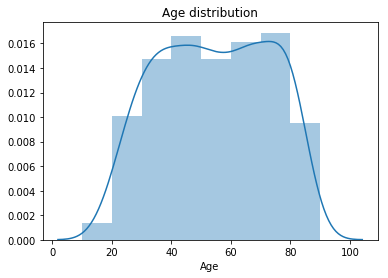

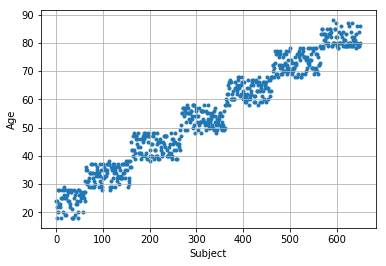

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [0]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


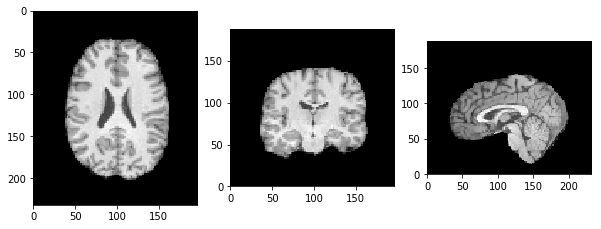

Brain mask (used in part A)


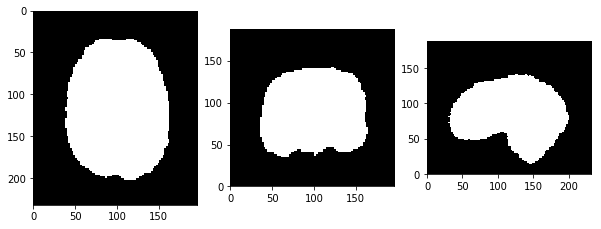

Spatially normalised grey matter maps (used in part B and C)


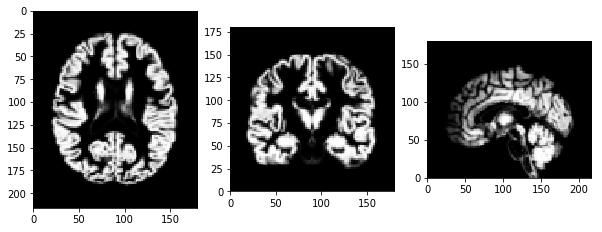

In [0]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. **Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume.** To this end, **a four-class (GM, WM, CSF, and background) brain segmentation** needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated **using two-fold cross-validation on the set of 500 subjects**, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.


### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tqdm

#### Data Helpers

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""
    #spacing = (1., 1., 1.)
    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [0]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.



In [0]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [0]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


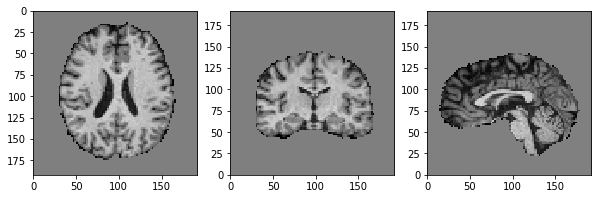

Segmentation


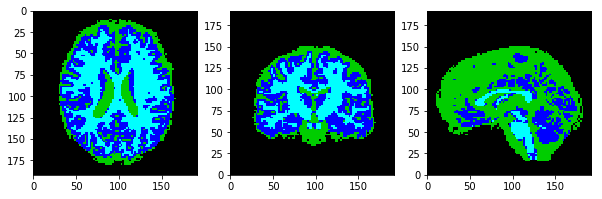

Mask


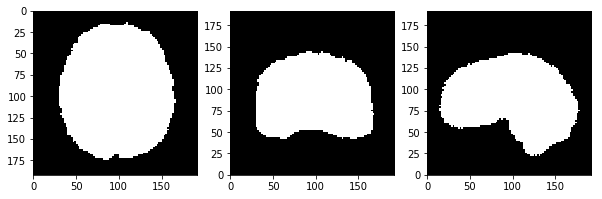

In [0]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [0]:


class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

In [0]:
class Downsample(nn.Module):
  def __init__(self):
    super(Downsample, self).__init__()
    self.maxpool = nn.MaxPool3d(kernel_size=2)
  
  def forward(self, x):
    out = self.maxpool(x)
    return out

class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Upsample, self).__init__()
    self.up = nn.ConvTranspose3d(in_channels, out_channels,  kernel_size=2, stride=2)

  def forward(self, x, y):
    x = self.up(x)
    y = y.detach()
    out = torch.cat((x,y), dim =1)
    return out

class TwiceConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TwiceConv, self).__init__()
    self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
    self.twice_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2,inplace=True)
            )

  def forward(self, x):
    shortcut = self.conv(x)
    out = self.twice_conv(x)
    out = F.relu(out+shortcut)
    return out


class Unet(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(Unet, self).__init__()
    basis = 32
    self.tw_conv1 = TwiceConv(1, basis) # in 64*64*64
    self.down1 = Downsample()  
    self.tw_conv2 = TwiceConv(basis, basis*2) # in 32*32*32
    self.down2 = Downsample()
    self.tw_conv3 = TwiceConv(basis*2, basis*4) #in 16*16*16
    self.down3 = Downsample()
    self.tw_conv4 = TwiceConv(basis*4, basis*8) #in 8*8*8
    self.down4 = Downsample()
    self.tw_conv5 = TwiceConv(basis*8, basis*16) #in 4*4*4
    self.up1 = Upsample(basis*16, basis*8)
    self.tw_conv6 = TwiceConv(basis*16, basis*8) #in 8*8*8
    self.up2 = Upsample(basis*8, basis*4)
    self.tw_conv7 = TwiceConv(basis*8, basis*4) #in 16*16*16
    self.up3 = Upsample(basis*4, basis*2)
    self.tw_conv8 = TwiceConv(basis*4, basis*2) #in 32*32*32
    self.up4 = Upsample(basis*2, basis)
    self.tw_conv9 = TwiceConv(basis*2, basis) #in 64*64*64
    self.out_conv = nn.Conv3d(basis, num_classes, kernel_size=3, stride=1, padding=1)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    x1 = self.tw_conv1(x)
    x2 = self.tw_conv2(self.down1(x1))
    x3 = self.tw_conv3(self.down2(x2))
    x4 = self.tw_conv4(self.down3(x3))
    x5 = self.tw_conv5(self.down4(x4))
    x6 = self.tw_conv6(self.up1(x5, x4))
    x7 = self.tw_conv7(self.up2(x6, x3))
    x8 = self.tw_conv8(self.up3(x7, x2))
    x9 = self.tw_conv9(self.up4(x8, x1))
    out = self.out_conv(x9)
    #out = self.softmax(out)
    return out

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

In [0]:
def train(model, optimizer, dataloader_train, dataloader_val, num_epochs):
  model.train()
  loss_train_log = []
  loss_val_log = []
  epoch_val_log = []    
  print('START TRAINING...')
  for epoch in tqdm_notebook(range(1, num_epochs + 1)):

      # Training
      for batch_idx, batch_samples in enumerate(dataloader_train):
          img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
          optimizer.zero_grad()
          prd = model(img)
          prd_flat = prd.view(prd.size(0), prd.size(1), -1)
          seg_flat = seg.view(seg.size(0), seg.size(1), -1)
          loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
          loss.backward()
          optimizer.step()

      loss_train_log.append(loss.item())

      print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
      if epoch == 1 or epoch % val_interval == 0:
        loss_val = validation(model, dataloader_val, epoch)
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        model.train()
  torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

  print('\nFinished TRAINING.')

  plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
  plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
  plt.legend(loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

def validation(model, dataloader_val, epoch):    
  # Validation
  model.eval() 
  loss_val = 0
  sum_pts = 0
  with torch.no_grad():
      for data_sample in dataloader_val:
          img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
          prd = model(img)
          prd_flat = prd.view(prd.size(0), prd.size(1), -1)
          seg_flat = seg.view(seg.size(0), seg.size(1), -1)
          loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
          sum_pts += seg_flat.size(2)         
  prd = torch.argmax(prd, dim=1)
  prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

  loss_val /= sum_pts

  print('--------------------------------------------------')
  print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
  display_image(sitk.LabelToRGB(prediction))
  print('--------------------------------------------------')
  return loss_val

In [0]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

#model = SimpleNet3D(num_classes=num_classes).to(device)
model = Unet(1, num_classes).to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#print(params)

START TRAINING...


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+ TRAINING 	Epoch: 1 	Loss: 0.159133
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.564829


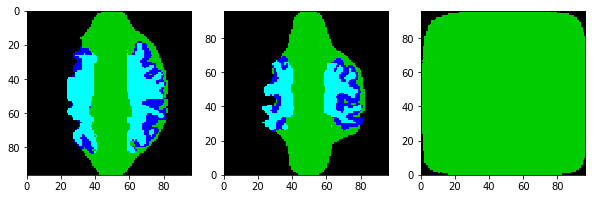

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.151146
+ TRAINING 	Epoch: 3 	Loss: 0.129154
+ TRAINING 	Epoch: 4 	Loss: 0.104509
+ TRAINING 	Epoch: 5 	Loss: 0.105161
+ TRAINING 	Epoch: 6 	Loss: 0.091489
+ TRAINING 	Epoch: 7 	Loss: 0.084209
+ TRAINING 	Epoch: 8 	Loss: 0.122620
+ TRAINING 	Epoch: 9 	Loss: 0.120731
+ TRAINING 	Epoch: 10 	Loss: 0.077210
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.091193


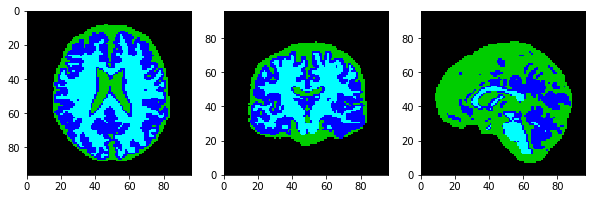

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.081957
+ TRAINING 	Epoch: 12 	Loss: 0.102118
+ TRAINING 	Epoch: 13 	Loss: 0.081471
+ TRAINING 	Epoch: 14 	Loss: 0.079891
+ TRAINING 	Epoch: 15 	Loss: 0.094815
+ TRAINING 	Epoch: 16 	Loss: 0.065228
+ TRAINING 	Epoch: 17 	Loss: 0.108991
+ TRAINING 	Epoch: 18 	Loss: 0.078961
+ TRAINING 	Epoch: 19 	Loss: 0.093755
+ TRAINING 	Epoch: 20 	Loss: 0.075849
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.075406


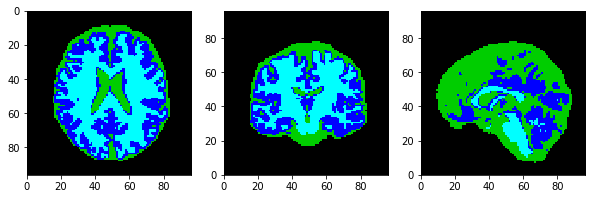

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.068265
+ TRAINING 	Epoch: 22 	Loss: 0.072054
+ TRAINING 	Epoch: 23 	Loss: 0.066717
+ TRAINING 	Epoch: 24 	Loss: 0.076739
+ TRAINING 	Epoch: 25 	Loss: 0.077899
+ TRAINING 	Epoch: 26 	Loss: 0.060531
+ TRAINING 	Epoch: 27 	Loss: 0.079743
+ TRAINING 	Epoch: 28 	Loss: 0.090363
+ TRAINING 	Epoch: 29 	Loss: 0.104678
+ TRAINING 	Epoch: 30 	Loss: 0.069274
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.076262


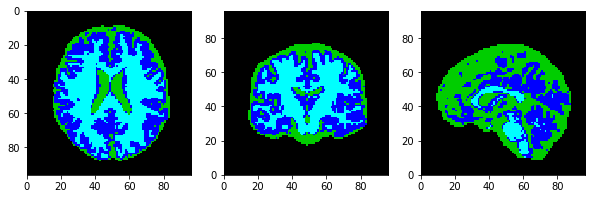

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.063213
+ TRAINING 	Epoch: 32 	Loss: 0.066834
+ TRAINING 	Epoch: 33 	Loss: 0.065189
+ TRAINING 	Epoch: 34 	Loss: 0.070097
+ TRAINING 	Epoch: 35 	Loss: 0.112794
+ TRAINING 	Epoch: 36 	Loss: 0.053190
+ TRAINING 	Epoch: 37 	Loss: 0.081692
+ TRAINING 	Epoch: 38 	Loss: 0.089820
+ TRAINING 	Epoch: 39 	Loss: 0.075393
+ TRAINING 	Epoch: 40 	Loss: 0.050245
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.077664


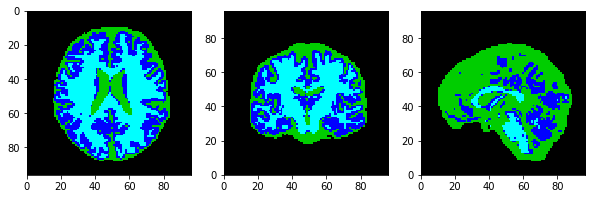

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.053591
+ TRAINING 	Epoch: 42 	Loss: 0.066067
+ TRAINING 	Epoch: 43 	Loss: 0.056303
+ TRAINING 	Epoch: 44 	Loss: 0.060592
+ TRAINING 	Epoch: 45 	Loss: 0.055803
+ TRAINING 	Epoch: 46 	Loss: 0.056598
+ TRAINING 	Epoch: 47 	Loss: 0.064114
+ TRAINING 	Epoch: 48 	Loss: 0.050664
+ TRAINING 	Epoch: 49 	Loss: 0.061649
+ TRAINING 	Epoch: 50 	Loss: 0.051668
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.066698


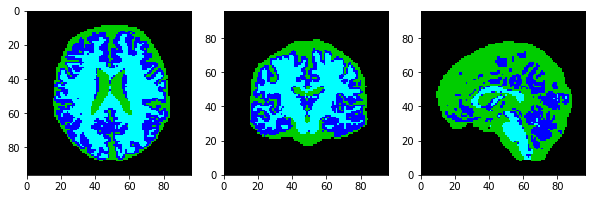

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.050976
+ TRAINING 	Epoch: 52 	Loss: 0.062565
+ TRAINING 	Epoch: 53 	Loss: 0.045218
+ TRAINING 	Epoch: 54 	Loss: 0.049989
+ TRAINING 	Epoch: 55 	Loss: 0.053731
+ TRAINING 	Epoch: 56 	Loss: 0.048996
+ TRAINING 	Epoch: 57 	Loss: 0.054721
+ TRAINING 	Epoch: 58 	Loss: 0.050069
+ TRAINING 	Epoch: 59 	Loss: 0.051632
+ TRAINING 	Epoch: 60 	Loss: 0.044243
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.062762


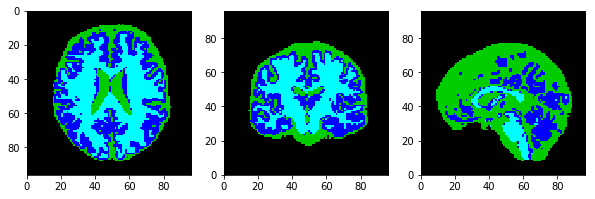

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.037889
+ TRAINING 	Epoch: 62 	Loss: 0.040412
+ TRAINING 	Epoch: 63 	Loss: 0.043940
+ TRAINING 	Epoch: 64 	Loss: 0.034374
+ TRAINING 	Epoch: 65 	Loss: 0.043194
+ TRAINING 	Epoch: 66 	Loss: 0.051355
+ TRAINING 	Epoch: 67 	Loss: 0.049086
+ TRAINING 	Epoch: 68 	Loss: 0.043988
+ TRAINING 	Epoch: 69 	Loss: 0.043157
+ TRAINING 	Epoch: 70 	Loss: 0.034611
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.063676


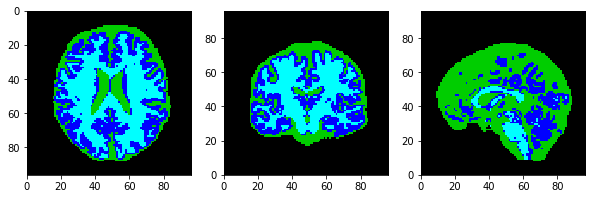

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.053042
+ TRAINING 	Epoch: 72 	Loss: 0.042190
+ TRAINING 	Epoch: 73 	Loss: 0.036993
+ TRAINING 	Epoch: 74 	Loss: 0.033643
+ TRAINING 	Epoch: 75 	Loss: 0.032623
+ TRAINING 	Epoch: 76 	Loss: 0.040641
+ TRAINING 	Epoch: 77 	Loss: 0.037836
+ TRAINING 	Epoch: 78 	Loss: 0.042714
+ TRAINING 	Epoch: 79 	Loss: 0.044345
+ TRAINING 	Epoch: 80 	Loss: 0.037167
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.065650


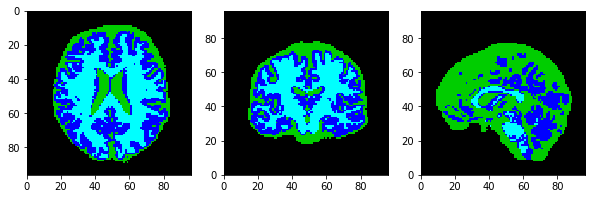

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.033001
+ TRAINING 	Epoch: 82 	Loss: 0.035217
+ TRAINING 	Epoch: 83 	Loss: 0.039592
+ TRAINING 	Epoch: 84 	Loss: 0.034859
+ TRAINING 	Epoch: 85 	Loss: 0.042033
+ TRAINING 	Epoch: 86 	Loss: 0.034171
+ TRAINING 	Epoch: 87 	Loss: 0.039939
+ TRAINING 	Epoch: 88 	Loss: 0.041484
+ TRAINING 	Epoch: 89 	Loss: 0.040718
+ TRAINING 	Epoch: 90 	Loss: 0.036707
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.072259


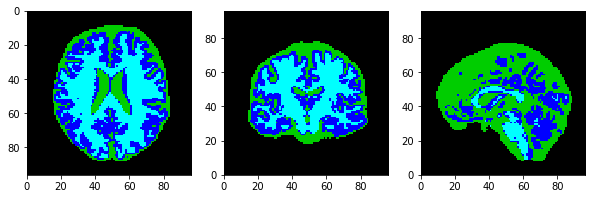

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.032223
+ TRAINING 	Epoch: 92 	Loss: 0.042532
+ TRAINING 	Epoch: 93 	Loss: 0.041327
+ TRAINING 	Epoch: 94 	Loss: 0.027841
+ TRAINING 	Epoch: 95 	Loss: 0.031002
+ TRAINING 	Epoch: 96 	Loss: 0.040084
+ TRAINING 	Epoch: 97 	Loss: 0.029245
+ TRAINING 	Epoch: 98 	Loss: 0.033817
+ TRAINING 	Epoch: 99 	Loss: 0.036068
+ TRAINING 	Epoch: 100 	Loss: 0.033424
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.075963


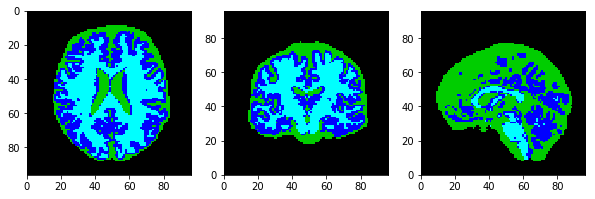

--------------------------------------------------


Finished TRAINING.


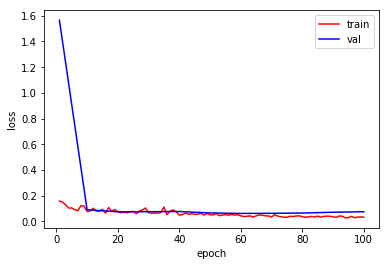

In [0]:
train(model, optimizer, dataloader_train, dataloader_val, num_epochs)

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [0]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


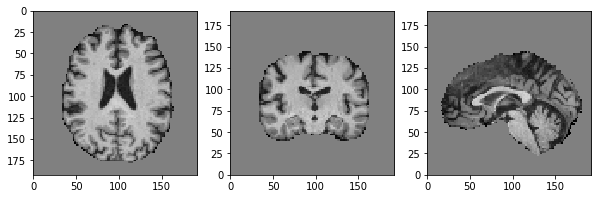

Segmentation


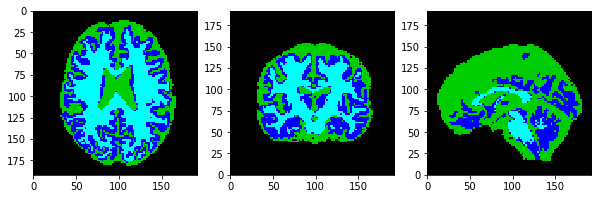

Mask


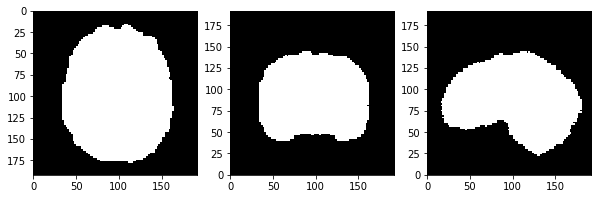

In [0]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder.


In [0]:
from scipy.spatial import distance
def dice_score(prd, seg):
  prd = prd.detach().cpu()
  seg = seg.detach().cpu()
  dice = []
  for j in range(num_classes):
    prd_bool = prd == j
    seg_bool = seg == j
    class_dice = []
    for i in range(prd.shape[0]):
      class_dice.append(distance.dice(prd_bool[i], seg_bool[i]))
    class_dice = np.array(class_dice)
    dice.append(class_dice)
  dice = np.array(dice)
  return dice

START TESTING...
+ TESTING 	Loss: 0.088838


Reference segmentation


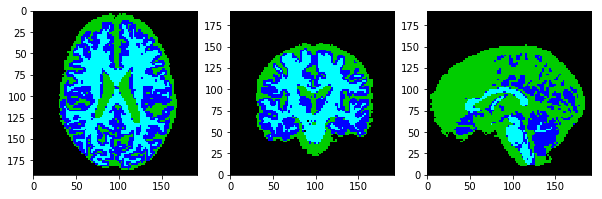

Predicted segmentation


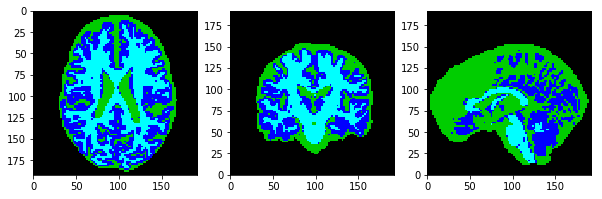


Finished TESTING.


In [0]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Unet(1, num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    dices = []
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        #compute dice score
        prd_flat_max = torch.argmax(prd_flat, dim=1, keepdim=True)
        dices.append(dice_score(prd_flat_max, seg_flat))
        idx_test += 1
        
dices = np.array(dices)

        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

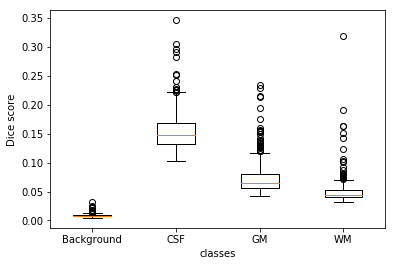

In [0]:
d = dices.transpose(0,2,1).reshape(-1,4)
plt.boxplot(d, labels=['Background', 'CSF', 'GM', 'WM'])
plt.xlabel('classes')
plt.ylabel('Dice score')
plt.savefig('box_plot.png')
plt.show()

### TASK A-2: Feature calculation

Start by **calculating the three absolute tissue volumes** for each subject. Plot the volumes against the subjects' ages. **Taking the absolute volumes of tissues as features**, however, might not be predictive. Instead, relative volumes need to be computed as the **ratios between each tissue volume and overall brain volume**. But you might also want to explore using **different combinations or even polynomial features**.

Implement a function that constructs a big matrix $X$ with **a row for each subject and features across the columns**. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [0]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os
import torchvision.transforms as T

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        vols[0 ,idx] = np.sum(seg_array==1)
        vols[1, idx] = np.sum(seg_array==2)
        vols[2, idx] = np.sum(seg_array==3)
          
        


Calculating Features: 100%|██████████| 500/500 [00:03<00:00, 160.90it/s]


Plot features versus age.

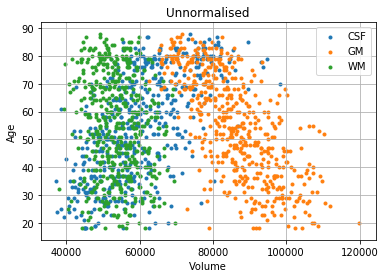

In [0]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [0]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        csf = np.sum(seg_array==1)
        gm = np.sum(seg_array==2)
        wm = np.sum(seg_array==3)
        overall = csf+gm+wm
        vols_normalised[0 ,idx] = csf/overall
        vols_normalised[1, idx] = gm/overall
        vols_normalised[2, idx] = wm/overall


Calculating Features: 100%|██████████| 500/500 [00:03<00:00, 160.86it/s]


Plot normalised features versus age.

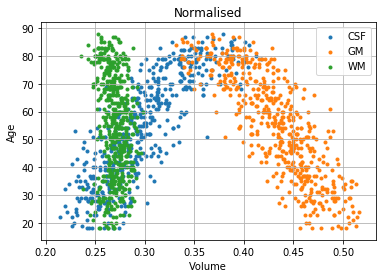

In [0]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.savefig('normalized_tissue.png')
plt.show()

Final data for age regression

In [0]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [0]:

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error


In [0]:
def train_linear_model(model, x, y, k=2):
  kf = KFold(n_splits=k, shuffle=True)
  MAE = np.zeros(k)
  R2 = np.zeros(k)
  MSE = np.zeros(k)
  count = 0
  for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    MAE[count] = mean_absolute_error(y_test, y_pred)
    R2[count] = r2_score(y_test, y_pred)
    MSE[count] = mean_squared_error(y_test, y_pred)
    count += 1
  return np.mean(MAE), np.mean(R2), np.mean(MSE)
  
def plot_linear_result(model, x, y):
  predicted = model.predict(x)
  print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
  print('r2 score: {0}'.format(r2_score(y,predicted)))
  print('mean square error: {0}'.format(mean_squared_error(y,predicted)))
  plt.scatter(y, predicted, marker='.')
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  plt.xlabel('Real Age')
  plt.ylabel('Predicted Age')
  plt.show() 

Doing linear regression

MAE cross validation: 8.72725
R2 cross validation: 0.6502532841841375
MSE cross validation: 118.41582812499999
mean absolute error: 8.43625
r2 score: 0.6743100481111098
mean square error: 110.856859375


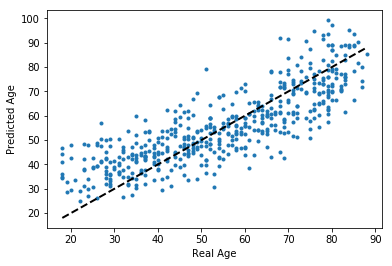

In [0]:
linear_regression = linear_model.LinearRegression()
linear_mae, linear_r2, linear_mse = train_linear_model(linear_regression, X, y)
print('MAE cross validation: {0}'.format(linear_mae))
print('R2 cross validation: {0}'.format(linear_r2))
print('MSE cross validation: {0}'.format(linear_mse))
print('=======================================')
plot_linear_result(linear_regression, X, y)

Doing ridge regression

MAE cross validation: 8.579811250576327
R2 cross validation: 0.6729074704399409
MSE cross validation: 111.30307868171374
mean absolute error: 8.570333071404978
r2 score: 0.6737030989898196
mean square error: 111.063449946789


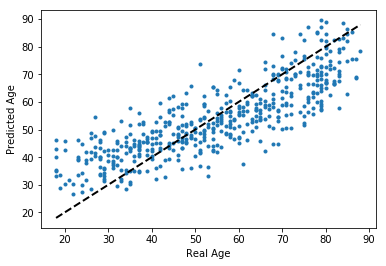

In [0]:
ridge_regression = linear_model.Ridge(alpha=0.1)
ridge_mae, ridge_r2, ridge_mse = train_linear_model(ridge_regression, X, y)
print('MAE cross validation: {0}'.format(ridge_mae))
print('R2 cross validation: {0}'.format(ridge_r2))
print('MSE cross validation: {0}'.format(ridge_mse))
print('=======================================')
plot_linear_result(ridge_regression, X, y)

Doing baysian regression

MAE cross validation: 8.48456997590732
R2 cross validation: 0.6758490063380798
MSE cross validation: 109.7067882652234
mean absolute error: 8.416116594151308
r2 score: 0.6818433045484851
mean square error: 108.29272393062858


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


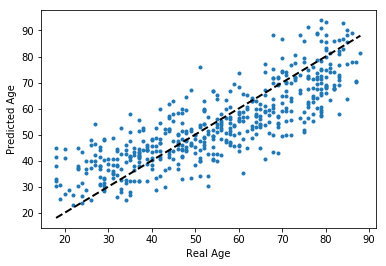

In [0]:
baysian_regression = linear_model.BayesianRidge()
baysian_mae, baysian_r2, baysian_mse = train_linear_model(baysian_regression, X, y)
print('MAE cross validation: {0}'.format(baysian_mae))
print('R2 cross validation: {0}'.format(baysian_r2))
print('MSE cross validation: {0}'.format(baysian_mse))
print('=======================================')
plot_linear_result(baysian_regression, X, y)

Error calculation and plotting

linear regression mean absolute error: 8.43625
linear regression r2 score: 0.6743100481111098
linear regression mean squared error: 110.856859375
ridge regression mean absolute error: 8.570333071404978
ridge regression r2 score: 0.6737030989898196
ridge regression mean squared error: 111.063449946789
baysian regression mean absolute error: 8.416116594151308
baysian regression r2 score: 0.6818433045484851
baysian regression mean squared error: 108.29272393062858


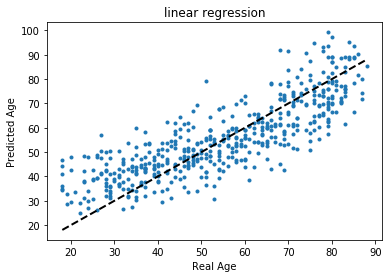

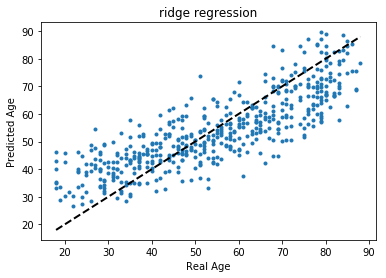

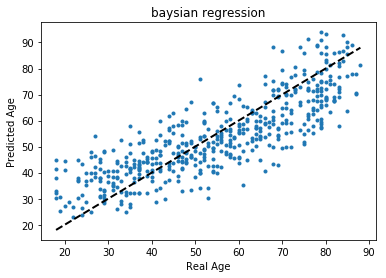

In [0]:
name_list = ['linear regression', 'ridge regression', 'baysian regression']
model_list = [linear_regression, ridge_regression, baysian_regression]

for i in range(3):
  predicted = model_list[i].predict(X)
  string1 = name_list[i]+' mean absolute error: '
  string2 = name_list[i]+' r2 score: '
  string3 = name_list[i]+' mean squared error: '
  print(string1+str(mean_absolute_error(y,predicted)))
  print(string2+str(r2_score(y,predicted)))
  print(string3+str(mean_squared_error(y,predicted)))
  print('==============================')

  fig, ax = plt.subplots()
  ax.scatter(y, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_title(name_list[i])
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.savefig(name_list[i]+'_cv.png')
plt.show()

### Test on test data

In [0]:
test_dir = './'
meta_data_reg_test = pd.read_csv(test_dir + 'meta_data_reg_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


In [0]:
pred_dir = os.path.join(out_dir, 'test')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Unet(1, num_classes)
model.load_state_dict(torch.load(os.path.join('./output/model/', 'model.pt')))
model.to(device)
model.eval()

idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img = data_sample['img'].to(device)
        prd = model(img)       
        prd = torch.argmax(prd, dim=1)
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        idx_test += 1

In [0]:
files_reg_seg_test = ['./output/test/' + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]

vols_normalised_test = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        csf = np.sum(seg_array==1)
        gm = np.sum(seg_array==2)
        wm = np.sum(seg_array==3)
        overall = csf+gm+wm
        vols_normalised_test[0 ,idx] = csf/overall
        vols_normalised_test[1, idx] = gm/overall
        vols_normalised_test[2, idx] = wm/overall

X_test = vols_normalised_test.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 159.65it/s]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


baysian regression mean absolute error: 8.687495695889394
baysian regression r2 score: 0.7135760922741441
baysian regression mean squared error: 108.31231775977254


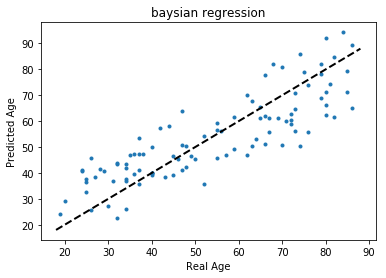

In [0]:
baysian = linear_model.BayesianRidge()
baysian.fit(X,y)
pre_test = baysian.predict(X_test)
print(string1+str(mean_absolute_error(y_test,pre_test)))
print(string2+str(r2_score(y_test,pre_test)))
print(string3+str(mean_squared_error(y_test,pre_test)))
print('==============================')

fig, ax = plt.subplots()
ax.scatter(y_test, pre_test, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_title(name_list[i])
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.savefig('partA_test_reg.png')
plt.show()

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.



### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

Load environment

In [0]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold

for final train and test

In [0]:



#data_dir = 'data/brain_age/'
def downsample(img, factor=2):
    smoothed = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
    return smoothed[::factor, ::factor, ::factor]

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_gm_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_train]

#meta_data_reg_test = pd.read_csv('drive/My Drive/meta_data_reg_test.csv')
meta_data_reg_test = pd.read_csv('./meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_gm_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_test]

img_data=[]
img_data_test=[]
k=0
for files in files_gm_train:
  k+=1
  img=sitk.ReadImage(files)
  img=downsample(img,2)
  #img_data.append(img)
  img = torch.from_numpy(sitk.GetArrayFromImage(img)).unsqueeze(0)
  img = img.numpy()
  img_data.append(img)
  #print(k)

for files in files_gm_test:
  k+=1
  img=sitk.ReadImage(files)
  img=downsample(img,2)
  #img_data.append(img)
  img = torch.from_numpy(sitk.GetArrayFromImage(img)).unsqueeze(0)
  img = img.numpy()
  img_data_test.append(img)
  #print(k)

img_data=np.array(img_data)
img_data_test=np.array(img_data_test)
#print(k)

In [0]:
X = img_data.reshape(500,-1)
y = meta_data_reg_train['age'].values.reshape(-1,1)

#print(img_size)
print(X.shape)
print(y.shape)

(500, 109350)
(500, 1)


for cross validation

In [0]:
from tqdm import tqdm

data_dir = 'data/brain_age/'
#fetch data from list
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_gm_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_train]

def downsampling_iso(img, factor=2):
    smoothed  = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)
    return smoothed[::factor, ::factor, ::factor]

def downsampling_aniso(img, factor=2):
    aniso_filter = sitk.GradientAnisotropicDiffusionImageFilter()
    # step = aniso_filter.EstimateOptimalTimeStep(img) # this line runs super slow
    smoothed = aniso_filter(img)
    return smoothed[::factor, ::factor, ::factor]

data_gms = []

for f in tqdm(files_gm_train, desc="preprocessing"):

    img = sitk.ReadImage(f)
    # img = downsampling_aniso(img) # anisotropic smoothing
    img = downsampling_iso(img)
    img = sitk.GetArrayFromImage(img)
    data_gms.append(img)


data_gms = np.array(data_gms)

preprocessing: 100%|██████████| 500/500 [00:56<00:00,  8.85it/s]


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:

from sklearn.decomposition import PCA
pca=PCA(n_components=0.95)
pca.fit(X)
X_reduce=pca.transform(X)
X_test_reduce=pca.transform(img_data_test.reshape(100,-1))

In [0]:
from sklearn.decomposition import PCA

def dimensions_reduction(X_train, X_test):
    
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    pca=PCA(n_components=0.95)
    pca.fit(X_train)
    X_train_reduced=pca.transform(X_train)
    X_test_reduced=pca.transform(X_test)
    return X_train_reduced, X_test_reduced

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [0]:
def train_linear_model(model, x, y, k=2):
  kf = KFold(n_splits=k, shuffle=True)
  MAE = np.zeros(k)
  R2 = np.zeros(k)
  MSE = np.zeros(k)
  count = 0
  for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    x_train, x_test = dimensions_reduction(x_train, x_test)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    MAE[count] = mean_absolute_error(y_test, y_pred)
    R2[count] = r2_score(y_test, y_pred)
    MSE[count] = mean_squared_error(y_test, y_pred)
    count += 1
  return np.mean(MAE), np.mean(R2), np.mean(MSE)

doing cross validation on each model

In [0]:
y= meta_data_reg_train['age'].values.ravel()

clf = svm.SVC(kernel='linear', C=1)
svm_mae, svm_r2, svm_mse = train_linear_model(clf, data_gms, y)
print('SVM')
print('MAE cross validation: {0}'.format(svm_mae))
print('R2 cross validation: {0}'.format(svm_r2))
print('MSE cross validation: {0}'.format(svm_mse))
print('=======================================')


linear_regression = linear_model.LinearRegression()
linear_mae, linear_r2, linear_mse = train_linear_model(linear_regression, data_gms, y)
print('Linear regression')
print('MAE cross validation: {0}'.format(linear_mae))
print('R2 cross validation: {0}'.format(linear_r2))
print('MSE cross validation: {0}'.format(linear_mse))
print('=======================================')


ridge_regression = linear_model.RidgeClassifier()
ridge_mae, ridge_r2, ridge_mse = train_linear_model(ridge_regression, data_gms, y)
print('Ridge regression')
print('MAE cross validation: {0}'.format(ridge_mae))
print('R2 cross validation: {0}'.format(ridge_r2))
print('MSE cross validation: {0}'.format(ridge_mse))
print('=======================================')


baysian_regression = linear_model.BayesianRidge()
baysian_mae, baysian_r2, baysian_mse = train_linear_model(baysian_regression, data_gms, y)
print('Baysian Regression')
print('MAE cross validation: {0}'.format(baysian_mae))
print('R2 cross validation: {0}'.format(baysian_r2))
print('MSE cross validation: {0}'.format(baysian_mse))
print('=======================================')

omp=sklearn.linear_model.OrthogonalMatchingPursuit()
omp_mae, omp_r2, omp_mse = train_linear_model(omp, data_gms, y)
print('Orthogonal Match pURSUIT')
print('MAE cross validation: {0}'.format(omp_mae))
print('R2 cross validation: {0}'.format(omp_r2))
print('MSE cross validation: {0}'.format(omp_mse))
print('=======================================')

SVM
MAE cross validation: 7.856
R2 cross validation: 0.7109221369135835
MSE cross validation: 98.28
Linear regression
MAE cross validation: 5.628088096618653
R2 cross validation: 0.8556258686097724
MSE cross validation: 49.19984857482649
Ridge regression
MAE cross validation: 10.82
R2 cross validation: 0.37698041424414047
MSE cross validation: 211.10399999999998
Baysian Regression
MAE cross validation: 5.819187242119348
R2 cross validation: 0.8463981355953898
MSE cross validation: 52.297138511421714
Orthogonal Match pURSUIT
MAE cross validation: 6.254054654600061
R2 cross validation: 0.8245479741999882
MSE cross validation: 59.787188639669495


final train on each model

In [0]:

y_test = meta_data_reg_test['age'].values.reshape(-1,1)
#X_test=img_data_test.reshape(100,-1)
y=y.reshape(-1,)

clf = svm.SVC(kernel='linear', C=1).fit(X_reduce,y)
y_pred=clf.predict(X_test_reduce)
score=mean_absolute_error(y_test,y_pred)
print("SVM MAE: {:.6f}".format(score))

lin=sklearn.linear_model.LinearRegression().fit(X_reduce,y)
y_pred1=lin.predict(X_test_reduce)
score1=mean_absolute_error(y_test,y_pred1)
print("Linear Regression MAE: {:.6f}".format(score1))

rc=sklearn.linear_model.RidgeClassifier().fit(X_reduce,y)
y_pred2=rc.predict(X_test_reduce)
score2=mean_absolute_error(y_test,y_pred2)
print("Ridge Regression MAE: {:.6f}".format(score2))

br=sklearn.linear_model.BayesianRidge().fit(X_reduce,y)
y_pred3=br.predict(X_test_reduce)
score3=mean_absolute_error(y_test,y_pred3)
print("Baysian Regression MAE: {:.6f}".format(score3))

omp=sklearn.linear_model.OrthogonalMatchingPursuit().fit(X_reduce,y)
y_pred4=omp.predict(X_test_reduce)
score4=mean_absolute_error(y_test,y_pred4)
print("Orthogonal matching pursuit MAE: {:.6f}".format(score))

SVM MAE: 6.710000
Linear Regression MAE: 5.520026
Ridge Regression MAE: 8.790000
Baysian Regression MAE: 5.561942
Orthogonal matching pursuit MAE: 6.710000


Error calculation and plotting

mean absolute error: 5.520026054382324
r2 score: 0.8874156371513221


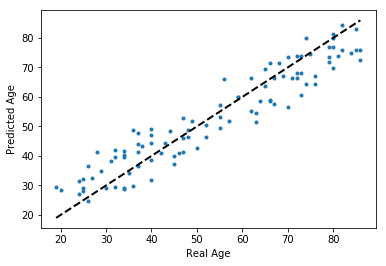

In [0]:
y=y_test
predicted=y_pred1
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.savefig('partB_regression.png')
plt.show()

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

### load environment

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import pandas as pd

### helper

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""
    #spacing = (1., 1., 1.)
    def __init__(self, file_list_img, file_list_grey, file_list_msk, ages, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.grey_names = []
        self.ages = ages
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            grey_path = file_list_grey[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            grey = sitk.ReadImage(grey_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            grey = resample_image(grey, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)
            age = ages[idx]

            sample = {'img': img, 'grey': grey, 'msk': msk, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.grey_names.append(os.path.basename(grey_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0).float()
        grey = torch.from_numpy(sitk.GetArrayFromImage(sample['grey'])).unsqueeze(0).float()
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0).float()
        age = sample['age']
        return {'img': image, 'grey': grey, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_grey_name(self, item):
        return self.grey_names[item]


### model

cnn

In [0]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_classes, basis):
        super(CNN, self).__init__()
        self.basis = basis
        self.num_classes = num_classes
        self.seq1 = nn.Sequential(nn.Conv3d(num_channels, self.basis, kernel_size=3, stride=1, padding=0),
                                  nn.ReLU(),
                                  nn.Conv3d(self.basis, self.basis, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq2 = nn.Sequential(nn.Conv3d(self.basis, self.basis*2, kernel_size=3, stride=1, padding=0),
                                  nn.ReLU(),
                                  nn.Conv3d(self.basis*2, self.basis*2, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*2),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq3 = nn.Sequential(nn.Conv3d(self.basis*2, self.basis*4, kernel_size=3, stride=1, padding=0),
                                  nn.ReLU(),
                                  nn.Conv3d(self.basis*4, self.basis*4, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*4),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq4 = nn.Sequential(nn.Conv3d(self.basis*4, self.basis*8, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.Conv3d(self.basis*8, self.basis*8, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm3d(self.basis*8),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq5 = nn.Sequential(nn.Conv3d(self.basis*8, self.basis*16, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.Conv3d(self.basis*16, self.basis*16, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm3d(self.basis*16),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(nn.Linear(in_features=self.basis*8*2*2*2, out_features=self.num_classes, bias=True),
                                #nn.ReLU(),
                                #nn.Dropout(0.2),
                                #nn.Linear(in_features=1024, out_features=self.num_classes, bias=True)
                                )

    def forward(self, x):
        n = x.shape[0]
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.seq3(x)
        #print(x.shape)
        x = self.seq4(x)
        #print(x.shape)
        #x = self.seq5(x)
        #print(x.shape)
        x = x.view(n, -1)
        out = self.fc(x)
        return out

Simple CNN

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self, num_channels, num_classes, basis):
        super(SimpleCNN, self).__init__()
        self.basis = basis
        self.num_classes = num_classes
        self.seq1 = nn.Sequential(nn.Conv3d(num_channels, self.basis, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq2 = nn.Sequential(nn.Conv3d(self.basis, self.basis*2, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*2),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq3 = nn.Sequential(nn.Conv3d(self.basis*2, self.basis*4, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*4),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq4 = nn.Sequential(nn.Conv3d(self.basis*4, self.basis*8, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*8),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.seq5 = nn.Sequential(nn.Conv3d(self.basis*8, self.basis*16, kernel_size=3, stride=1, padding=0),
                                  nn.BatchNorm3d(self.basis*16),
                                  nn.ReLU(),
                                  nn.MaxPool3d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(nn.Linear(in_features=self.basis*8*2*2*2, out_features=self.num_classes, bias=True),
                                #nn.ReLU(),
                                #nn.Dropout(0.2),
                                #nn.Linear(in_features=1024, out_features=self.num_classes, bias=True)
                                )

    def forward(self, x):
        n = x.shape[0]
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.seq3(x)
        #print(x.shape)
        x = self.seq4(x)
        #print(x.shape)
        #x = self.seq5(x)
        #print(x.shape)
        x = x.view(n, -1)
        out = self.fc(x)
        return out

LeNet

In [0]:
class LeNet(nn.Module):
    def __init__(self, num_channels, num_classes, basis):
        super(LeNet, self).__init__()
        self.basis = basis
        self.num_classes = num_classes
        self.conv1 = nn.Conv3d(num_channels, 8, kernel_size=5)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=5)
        #self.conv3 = nn.Conv3d(6, 16, kernel_size=3)
        #self.conv4 = nn.Conv3d(16,16, kernel_size=3)
        self.fc1 = nn.Linear(16*13*13*13, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, self.num_classes)
        self.pool = nn.MaxPool3d(2,2)

    def forward(self, x):
        n = x.shape[0]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = x.view(n, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

ResNet

In [0]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResBlock, self).__init__() 
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.conv = nn.Sequential(nn.Conv3d(self.in_channel, self.out_channel, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm3d(self.out_channel),
                                  nn.ReLU(),
                                  nn.Conv3d(self.out_channel, self.out_channel, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm3d(self.out_channel)
                                  #nn.ReLU()
                                  )
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
#         self.conv2 = nn.Sequential(nn.Conv3d(self.out_channel, self.out_channel, kernel_size=3, stride=1, padding=1),
#                                   nn.BatchNorm3d(self.out_channel),
#                                   nn.ReLU(),
#                                   nn.Conv3d(self.out_channel, self.out_channel, kernel_size=3, stride=1, padding=1),
#                                   nn.BatchNorm3d(self.out_channel)
#                                   #nn.ReLU()
#                                   )
        self.resi = nn.Conv3d(self.in_channel, self.out_channel, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x_conv = self.conv(x)
        if self.in_channel != self.out_channel:
            x_res = self.resi(x)
        else:
            x_res = x
        out = x_res+x_conv
        #out = self.conv2(out)+out
        out = self.maxpool(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_channel, num_classes, basis):
        super(ResNet, self).__init__()
        self.in_channel = in_channel
        self.num_classes = num_classes
        self.basis = basis
        self.res1 = ResBlock(self.in_channel, self.basis)
        self.res2 = ResBlock(self.basis, self.basis*2)
        self.res3 = ResBlock(self.basis*2, self.basis*4)
        self.res4 = ResBlock(self.basis*4, self.basis*8)
        self.res5 = ResBlock(self.basis*8, self.basis*16)
        self.fc = nn.Linear(self.basis*16*2*2*2, self.num_classes)
    
    def forward(self, x):
        n = x.shape[0]
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = x.view(n,-1)
        out = self.fc(x)

        return out
          

Unet

In [0]:
class Downsample(nn.Module):
  def __init__(self):
    super(Downsample, self).__init__()
    self.maxpool = nn.MaxPool3d(kernel_size=2)
  
  def forward(self, x):
    out = self.maxpool(x)
    return out

class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Upsample, self).__init__()
    self.up = nn.ConvTranspose3d(in_channels, out_channels,  kernel_size=2, stride=2)

  def forward(self, x, y):
    x = self.up(x)
    y = y.detach()
    out = torch.cat((x,y), dim =1)
    return out

class TwiceConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TwiceConv, self).__init__()
    self.twice_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
            )

  def forward(self, x):
    out = self.twice_conv(x)
    return out

class Unet(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(Unet, self).__init__()
    basis = 32
    self.tw_conv1 = TwiceConv(1, basis) # in 64*64*64
    self.down1 = Downsample()  
    self.tw_conv2 = TwiceConv(basis, basis*2) # in 32*32*32
    self.down2 = Downsample()
    self.tw_conv3 = TwiceConv(basis*2, basis*4) #in 16*16*16
    self.down3 = Downsample()
    self.tw_conv4 = TwiceConv(basis*4, basis*8) #in 8*8*8
    self.down4 = Downsample()
    self.tw_conv5 = TwiceConv(basis*8, basis*16) #in 4*4*4
    self.up1 = Upsample(basis*16, basis*8)
    self.tw_conv6 = TwiceConv(basis*16, basis*8) #in 8*8*8
    self.up2 = Upsample(basis*8, basis*4)
    self.tw_conv7 = TwiceConv(basis*8, basis*4) #in 16*16*16
    self.up3 = Upsample(basis*4, basis*2)
    self.tw_conv8 = TwiceConv(basis*4, basis*2) #in 32*32*32
    self.up4 = Upsample(basis*2, basis)
    self.tw_conv9 = TwiceConv(basis*2, basis) #in 64*64*64
    self.out_conv = nn.Linear(basis*64*64*64, 1)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, x):
    n = x.shape[0]
    x1 = self.tw_conv1(x)
    x2 = self.tw_conv2(self.down1(x1))
    x3 = self.tw_conv3(self.down2(x2))
    x4 = self.tw_conv4(self.down3(x3))
    x5 = self.tw_conv5(self.down4(x4))
    x6 = self.tw_conv6(self.up1(x5, x4))
    x7 = self.tw_conv7(self.up2(x6, x3))
    x8 = self.tw_conv8(self.up3(x7, x2))
    x9 = self.tw_conv9(self.up4(x8, x1))
    x9 = x9.view(n,-1)
    out = self.out_conv(x9)
    #out = self.softmax(out)
    return out

### training and testing

In [0]:

def train(model, optimizer, dataloader_train, dataloader_val, num_epochs, val_interval):
  model.train()
  for epoch in tqdm_notebook(range(1, num_epochs + 1)):
      # Training
      mae_train = 0
      train_loss = 0
      count = 0
      for _, batch_samples in enumerate(dataloader_train):
          grey, age = batch_samples['grey'].to(device), batch_samples['age'].to(device)
          optimizer.zero_grad()
          prd = model(grey)
          loss = F.l1_loss(prd, age)
          loss.backward()
          optimizer.step()
          mae_train += F.l1_loss(prd, age).item()
          train_loss += F.mse_loss(prd, age).item()
          count += 1
      
      print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, train_loss/count, mae_train/count))
      
      if epoch == 1 or epoch % val_interval == 0:
        validation(model, dataloader_val)
        model.train()

  torch.save(model.state_dict(), os.path.join(model_dir, 'model_part3.pt'))
  val_loss, val_mae = validation(model, dataloader_val)
  return val_loss, val_mae

# plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
# plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
# plt.legend(loc='upper right')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

def validation(model, dataloader_val):    
  # Validation
  model.eval() 
  loss_val = 0
  count = 0
  mae_val = 0
  with torch.no_grad():
      for data_sample in dataloader_val:
          grey, age = data_sample['grey'].to(device), data_sample['age'].to(device)
          prd = model(grey)
          loss_val += F.mse_loss(prd, age).item()
          mae_val += F.l1_loss(prd, age).item()
          count += 1

  loss_val /= count
  mae_val /= count
  print('--------------------------------------------------')
  print('+ VALIDATE \tLoss: {:.6f} \tMAE: {:.6f}'.format(loss_val, mae_val))

  return loss_val, mae_val

### cross validation

In [0]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [1, 1, 1]

num_epochs = 65
learning_rate = 0.0005
batch_size = 8
val_interval = 20

num_classes = 1

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [0]:
data_dir = './data/brain_age/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
ages = torch.Tensor(meta_data_reg_train['age']).view(-1,1)
files_reg_grey_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_train]
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]

In [0]:
kf = KFold(n_splits=2, shuffle=True)
cv_loss = 0
cv_mae = 0
count = 0
for idx, (train_idx, test_idx) in tqdm_notebook(enumerate(kf.split(files_reg_grey_train))):
    train_grey = np.array(files_reg_grey_train)[train_idx]
    validation_grey = np.array(files_reg_grey_train)[test_idx]
    train_img = np.array(files_reg_img_train)[train_idx]
    validation_img = np.array(files_reg_img_train)[test_idx]
    train_msk = np.array(files_reg_msk_train)[train_idx]
    validation_msk = np.array(files_reg_msk_train)[test_idx]
    train_age = ages[train_idx]
    validation_age = ages[test_idx]

    dataset_train = ImageSegmentationDataset(train_img, train_grey, train_msk, train_age, img_spacing, img_size)
    dataset_validation = ImageSegmentationDataset(validation_img, validation_grey, validation_msk, validation_age, img_spacing, img_size)

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)

    model_dir = os.path.join(out_dir, 'model')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    torch.manual_seed(rnd_seed) #fix random seed

    #######################################MODEL#########################################
    model = ResNet(1, num_classes, 64).to(device) 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    fold_loss, fold_mae = train(model, optimizer, train_loader, validation_loader, num_epochs, val_interval)
    print("fold_loss: {:.6f}, fold_MAE: {:.6f}".format(fold_loss, fold_mae))
    cv_loss += fold_loss
    cv_mae += fold_mae
    count += 1

print("CV_loss: {:.6f}, CV_MAE: {:.6f}".format(cv_loss/count, cv_mae/count))


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Loading Data: 100%|██████████| 250/250 [00:36<00:00,  6.87it/s]
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+ TRAINING 	Epoch: 1 	Loss: 1981.101365 	MAE: 31.790422
--------------------------------------------------
+ VALIDATE 	Loss: 374.394185 	MAE: 16.024587
+ TRAINING 	Epoch: 2 	Loss: 371.143580 	MAE: 15.483097
+ TRAINING 	Epoch: 3 	Loss: 344.422548 	MAE: 15.075873
+ TRAINING 	Epoch: 4 	Loss: 395.612716 	MAE: 15.707011
+ TRAINING 	Epoch: 5 	Loss: 285.490609 	MAE: 13.708067
+ TRAINING 	Epoch: 6 	Loss: 212.278011 	MAE: 11.694169
+ TRAINING 	Epoch: 7 	Loss: 281.422471 	MAE: 13.076929
+ TRAINING 	Epoch: 8 	Loss: 206.420868 	MAE: 11.700967
+ TRAINING 	Epoch: 9 	Loss: 290.887635 	MAE: 13.383203
+ TRAINING 	Epoch: 10 	Loss: 175.868161 	MAE: 10.342347
+ TRAINING 	Epoch: 11 	Loss: 189.084001 	MAE: 10.455669
+ TRAINING 	Epoch: 12 	Loss: 138.760791 	MAE: 9.326581
+ TRAINING 	Epoch: 13 	Loss: 159.721075 	MAE: 10.060139
+ TRAINING 	Epoch: 14 	Loss: 136.826734 	MAE: 8.787972
+ TRAINING 	Epoch: 15 	Loss: 98.080047 	MAE: 7.545538
+ TRAINING 	Epoch: 16 	Loss: 94.363663 	MAE: 7.336102
+ TRAINING 	Epoch: 17 

Loading Data:   0%|          | 1/250 [00:00<00:35,  6.98it/s]

--------------------------------------------------
+ VALIDATE 	Loss: 179.404157 	MAE: 10.523875
fold_loss: 179.404157, fold_MAE: 10.523875


Loading Data: 100%|██████████| 250/250 [00:35<00:00,  6.99it/s]


+ TRAINING 	Epoch: 1 	Loss: 1798.822561 	MAE: 29.466952
--------------------------------------------------
+ VALIDATE 	Loss: 633.669557 	MAE: 20.558252
+ TRAINING 	Epoch: 2 	Loss: 380.945610 	MAE: 15.755691
+ TRAINING 	Epoch: 3 	Loss: 321.697788 	MAE: 14.117942
+ TRAINING 	Epoch: 4 	Loss: 244.982121 	MAE: 12.977602
+ TRAINING 	Epoch: 5 	Loss: 256.896018 	MAE: 12.845325
+ TRAINING 	Epoch: 6 	Loss: 190.653427 	MAE: 11.165050
+ TRAINING 	Epoch: 7 	Loss: 224.442498 	MAE: 11.671102
+ TRAINING 	Epoch: 8 	Loss: 184.778281 	MAE: 10.741477
+ TRAINING 	Epoch: 9 	Loss: 164.605272 	MAE: 10.160102
+ TRAINING 	Epoch: 10 	Loss: 152.365225 	MAE: 9.365159
+ TRAINING 	Epoch: 11 	Loss: 217.792066 	MAE: 11.692552
+ TRAINING 	Epoch: 12 	Loss: 133.352215 	MAE: 8.756645
+ TRAINING 	Epoch: 13 	Loss: 203.403674 	MAE: 11.815705
+ TRAINING 	Epoch: 14 	Loss: 149.300871 	MAE: 9.410527
+ TRAINING 	Epoch: 15 	Loss: 156.759823 	MAE: 9.539758
+ TRAINING 	Epoch: 16 	Loss: 123.046016 	MAE: 8.382225
+ TRAINING 	Epoch: 17

## Train on hold dataset

In [0]:
def train_whole(model, optimizer, dataloader_train, num_epochs):
  model.train()
  for epoch in tqdm_notebook(range(1, num_epochs + 1)):
      # Training
      mae_train = 0
      train_loss = 0
      count = 0
      for _, batch_samples in enumerate(dataloader_train):
          grey, age = batch_samples['grey'].to(device), batch_samples['age'].to(device)
          optimizer.zero_grad()
          prd = model(grey)
          loss = F.l1_loss(prd, age)
          loss.backward()
          optimizer.step()
          mae_train += F.l1_loss(prd, age).item()
          train_loss += F.mse_loss(prd, age).item()
          count += 1
      
      print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, train_loss/count, mae_train/count))

  torch.save(model.state_dict(), os.path.join(model_dir, 'model_part3_whole.pt'))

In [0]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla P4


In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]#[96, 96, 96]
img_spacing = [1, 1, 1]

num_epochs = 60
learning_rate = 0.0005
batch_size = 8
val_interval = 10

num_classes = 1

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

data_dir = './data/brain_age/'
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
ages = torch.Tensor(meta_data_reg_train['age']).view(-1,1)
files_reg_grey_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_train]
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]

train_grey = np.array(files_reg_grey_train)
train_img = np.array(files_reg_img_train)
train_msk = np.array(files_reg_msk_train)
train_age = ages

dataset_train = ImageSegmentationDataset(train_img, train_grey, train_msk, train_age, img_spacing, img_size)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

#######################################MODEL#########################################
model = ResNet(1, num_classes, 64).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_whole(model, optimizer, train_loader, num_epochs)

Loading Data: 100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


+ TRAINING 	Epoch: 1 	Loss: 1105.806904 	MAE: 21.516348
+ TRAINING 	Epoch: 2 	Loss: 290.420663 	MAE: 13.657040
+ TRAINING 	Epoch: 3 	Loss: 242.695632 	MAE: 12.375355
+ TRAINING 	Epoch: 4 	Loss: 436.183012 	MAE: 16.468749
+ TRAINING 	Epoch: 5 	Loss: 227.809781 	MAE: 11.814917
+ TRAINING 	Epoch: 6 	Loss: 177.606879 	MAE: 10.490875
+ TRAINING 	Epoch: 7 	Loss: 167.847874 	MAE: 9.904681
+ TRAINING 	Epoch: 8 	Loss: 164.525977 	MAE: 10.017370
+ TRAINING 	Epoch: 9 	Loss: 134.307602 	MAE: 8.994419
+ TRAINING 	Epoch: 10 	Loss: 145.320409 	MAE: 9.387888
+ TRAINING 	Epoch: 11 	Loss: 144.699695 	MAE: 9.390243
+ TRAINING 	Epoch: 12 	Loss: 122.529951 	MAE: 8.490938
+ TRAINING 	Epoch: 13 	Loss: 120.304096 	MAE: 8.456075
+ TRAINING 	Epoch: 14 	Loss: 162.104829 	MAE: 9.866529
+ TRAINING 	Epoch: 15 	Loss: 113.534316 	MAE: 8.036666
+ TRAINING 	Epoch: 16 	Loss: 111.802837 	MAE: 7.892877
+ TRAINING 	Epoch: 17 	Loss: 133.469011 	MAE: 8.967441
+ TRAINING 	Epoch: 18 	Loss: 114.730088 	MAE: 8.276709
+ TRAINING 

### Error calculation and plotting

In [0]:
def test(model, dataloader_test):    
  # test
  model.eval() 
  mae_test = 0
  prd_list = []
  age_list = []
  count = 0
  with torch.no_grad():
      for data_sample in dataloader_test:
          grey, age = data_sample['grey'].to(device), data_sample['age'].to(device)
          prd = model(grey)
          mae_test += F.l1_loss(prd, age).item()
          prd_list.append(prd.cpu())
          age_list.append(age.cpu())
          count += 1

  print('--------------------------------------------------')
  print('+ Test  \tMAE: {:.6f}'.format(mae_test/count))

  return prd_list, age_list

load test data

In [0]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [1, 1, 1]
num_classes = 1

batch_size = 8

In [0]:
data_dir = './data/brain_age/'

meta_data_reg_test = pd.read_csv('./meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
test_age = torch.Tensor(meta_data_reg_test['age']).view(-1,1)
test_grey = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg_test]
test_img = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
test_msk = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]

dataset_test = ImageSegmentationDataset(test_img, test_grey, test_msk, test_age, img_spacing, img_size)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


load model

In [0]:
model = ResNet(1, num_classes, 64)
model = model.to(device)
#model.load_state_dict(torch.load('./output/model/model_part3.pt'))
model.load_state_dict(torch.load('./output/model/model_part3_whole.pt'))

predicted, y = test(model, test_loader)
predicted = torch.cat(predicted)
y = torch.cat(y)

--------------------------------------------------
+ Test  	MAE: 7.668284


mean absolute error: 7.570805549621582
r2 score: 0.7147955363098023


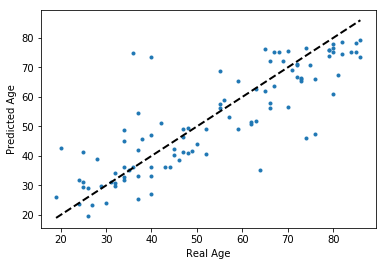

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.savefig('partc.png')
plt.show()